In [2]:
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

env: LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/


In [ ]:
import os
print(os.environ["LD_LIBRARY_PATH"])

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import keras

from keras import Sequential, models, Input
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import SGD, Adam

In [2]:
from tensorflow.python.client import device_lib

#print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-10-12 18:07:30.765311: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-12 18:07:30.765469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Read the csv dataset to get the values for stage and discharge of the images

In [3]:
df = pd.read_csv("../dataset/2012_2019_PlatteRiverWeir_features_merged_all.csv")
df.head()

,Unnamed: 0,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:47,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:55,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df = df[["Filename", "Stage", "Discharge"]]

### Scale the data

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [6]:
df[["Stage", "Discharge"]] = scaler.fit_transform(df[["Stage", "Discharge"]])
df


,Filename,Stage,Discharge
0,StateLineWeir_20120609_Farrell_001.jpg,0.138117,-0.046094
1,StateLineWeir_20120609_Farrell_002.jpg,0.138117,-0.046094
2,StateLineWeir_20120609_Farrell_003.jpg,0.100875,-0.082160
3,StateLineWeir_20120609_Farrell_004.jpg,0.076046,-0.104807
4,StateLineWeir_20120609_Farrell_005.jpg,0.076046,-0.104807
...,...,...,...
42054,StateLineWeir_20191011_Farrell_409.jpg,-0.420526,-0.450369
42055,StateLineWeir_20191011_Farrell_410.jpg,-0.420526,-0.450369
42056,StateLineWeir_20191011_Farrell_411.jpg,-0.420526,-0.450369
42057,StateLineWeir_20191011_Farrell_412.jpg,-0.420526,-0.450369


## Create the dataset pipeline

In [7]:
IMG_SIZE = 512

In [8]:
from glob import glob

def make_dataset(path, batch_size, df, seed=None):
  np.random.seed(seed)

  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32)
    image /= 255
    return image

  def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=100)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

  filenames = glob(path + '/*')
  # make train, val and test splits of the dataset
  split1 = int(0.7 * len(filenames))
  split2 = int(0.8 * len(filenames))

  np.random.shuffle(filenames)
  train_files = filenames[:split1] # up to split 1 (ex 70%)
  val_files = filenames[split1:split2] # from ex. 70% to 80%
  test_files = filenames[split2:] # from ex. 80% until the end

  # create stage values
  stage_train_values = [df[df.Filename == file.split('/')[-1]].Stage.values for file in train_files]
  stage_val_values = [df[df.Filename == file.split('/')[-1]].Stage.values for file in val_files]
  stage_test_values = [df[df.Filename == file.split('/')[-1]].Stage.values for file in test_files]

  # create discharge values
  discharge_train_values = [df[df.Filename == file.split(
      '/')[-1]].Discharge.values for file in train_files]
  discharge_val_values = [df[df.Filename == file.split(
      '/')[-1]].Discharge.values for file in val_files]
  discharge_test_values = [df[df.Filename == file.split(
      '/')[-1]].Discharge.values for file in test_files]

  # join stage and discharge values
  stage_discharge_train_values = [[np.squeeze(s), np.squeeze(d)] for s, d in zip(stage_train_values, discharge_train_values)]
  stage_discharge_val_values = [[np.squeeze(s), np.squeeze(d)] for s, d in zip(stage_val_values, discharge_val_values)]
  stage_discharge_test_values = [[np.squeeze(s), np.squeeze(
      d)] for s, d in zip(stage_test_values, discharge_test_values)]

  # create images dataset (train, val, test)
  filenames_train_ds = tf.data.Dataset.from_tensor_slices(train_files)
  filenames_val_ds = tf.data.Dataset.from_tensor_slices(val_files)
  filenames_test_ds = tf.data.Dataset.from_tensor_slices(test_files)

  images_train_ds = filenames_train_ds.map(parse_image, num_parallel_calls=5)
  images_val_ds = filenames_val_ds.map(parse_image, num_parallel_calls=5)
  images_test_ds = filenames_test_ds.map(parse_image, num_parallel_calls=5)

  # create stage and discharge dataset (train, val, test)
  stage_discharge_train_ds = tf.data.Dataset.from_tensor_slices(stage_discharge_train_values)
  stage_discharge_val_ds = tf.data.Dataset.from_tensor_slices(stage_discharge_val_values)
  stage_discharge_test_ds = tf.data.Dataset.from_tensor_slices(
      stage_discharge_test_values)

  # create tensorflow dataset of images and values (train, val, test)
  train_ds = tf.data.Dataset.zip((images_train_ds, stage_discharge_train_ds))
  train_ds = configure_for_performance(train_ds)
  val_ds = tf.data.Dataset.zip((images_val_ds, stage_discharge_val_ds))
  val_ds = configure_for_performance(val_ds)
  test_ds = tf.data.Dataset.zip((images_test_ds, stage_discharge_test_ds))
  test_ds = configure_for_performance(test_ds)

  return train_ds, len(train_files), val_ds, len(val_files), test_ds, len(test_files)

In [9]:
path = "../dataset/images_tmp"

train_ds, train_size, val_ds, val_size, test_ds, test_size = make_dataset(path, 32, df, 0)

2022-10-12 18:07:33.712612: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-12 18:07:33.712638: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
input_shape = 0
output_shape = 0

for image, stage_discharge in train_ds.take(1):
    print(image.numpy().shape)
    print(stage_discharge.numpy().shape)

    input_shape = image.numpy().shape[1:]
    output_shape = stage_discharge.numpy().shape[1:]

2022-10-12 18:07:33.871754: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(32, 512, 512, 3)
(32, 2)


In [11]:
print(input_shape)
print(output_shape)

(512, 512, 3)
(2,)


## Create model

In [151]:
def create_model(input_shape, output_shape):
    model = Sequential()

    model.add(Input(shape=input_shape))

    model.add(Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Conv2D(64, kernel_size=(4, 4), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dense(output_shape, activation='linear')) # linear regression output layer

    return model


In [152]:
model = create_model(input_shape, output_shape[0])

In [153]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 256, 256, 64)      3136      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 64, 64, 64)        65600     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 30, 30, 32)        18464     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 10, 10, 32)      

In [154]:
def compile_model(loss_func, optimizer, metrics=["accuracy"]):
    model.compile(loss=loss_func, optimizer=optimizer, metrics=metrics)

In [155]:
sgd = SGD(learning_rate=0.01, decay=1e-4, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=1e-3, decay=1e-3 / 200)

compile_model('mse', adam,  [
              'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])


In [156]:
def fit_model(training_values, validation_values=None, batch_size=32, epochs=10, steps=32, val_steps=32, callbacks=[]):
    return model.fit(training_values, validation_data=validation_values, batch_size=batch_size, epochs=epochs, steps_per_epoch=steps, validation_steps=val_steps, callbacks=callbacks)

In [158]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="model_weights/cnn_best_weights.hdf5",
                               monitor='val_mape',
                               verbose=1,
                               save_best_only=True)


In [160]:
# batch_size = 0 because we already have batch size in tf dataset
history = fit_model(train_ds, val_ds, batch_size=0, epochs=10, steps=np.ceil(train_size / 32), val_steps=np.ceil(val_size / 32), callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/10
11/11 [==============================] - ETA: 0s - loss: 1.0537 - mse: 1.0537 - rmse: 1.0265 - mae: 0.7650 - mape: 117.8319

2022-10-12 19:12:30.018645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_mape improved from inf to 112.79581, saving model to model_weights/cnn_best_weights.hdf5
11/11 [==============================] - 4s 367ms/step - loss: 1.0537 - mse: 1.0537 - rmse: 1.0265 - mae: 0.7650 - mape: 117.8319 - val_loss: 0.5799 - val_mse: 0.5799 - val_rmse: 0.7615 - val_mae: 0.6214 - val_mape: 112.7958
Epoch 2/10
11/11 [==============================] - ETA: 0s - loss: 1.0284 - mse: 1.0284 - rmse: 1.0141 - mae: 0.7441 - mape: 110.6322
Epoch 2: val_mape improved from 112.79581 to 108.40430, saving model to model_weights/cnn_best_weights.hdf5
11/11 [==============================] - 4s 350ms/step - loss: 1.0284 - mse: 1.0284 - rmse: 1.0141 - mae: 0.7441 - mape: 110.6322 - val_loss: 0.6020 - val_mse: 0.6020 - val_rmse: 0.7759 - val_mae: 0.6246 - val_mape: 108.4043
Epoch 3/10
11/11 [==============================] - ETA: 0s - loss: 1.0206 - mse: 1.0206 - rmse: 1.0103 - mae: 0.7325 - mape: 112.7788
Epoch 3: val_mape did not improve from 108.40430
11/11 [=============

## Evaluate model

In [161]:
def evaluate_model(test_values, steps):
  score = model.evaluate(test_values, steps=steps)
  return score

In [162]:
test_loss, test_mse, test_rmse, test_mae, test_mape = evaluate_model(test_ds, steps=np.ceil(test_size / 32))

4/4 [==============================] - 0s 68ms/step - loss: 0.8733 - mse: 0.8733 - rmse: 0.9345 - mae: 0.7058 - mape: 124.7180


In [163]:
predictions = model.predict(test_ds, steps=np.ceil(test_size / 32))

3/4 [=====================>........] - ETA: 0s

2022-10-12 19:13:01.255732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 44ms/step


In [164]:
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
for image, stage_discharge in train_ds.take(1):
	diff = predictions[:2].flatten() - stage_discharge[:2].numpy().flatten()
	percentDiff = (diff / stage_discharge[:2].numpy().flatten()) * 100
	absPercentDiff = np.abs(percentDiff)
	# compute the mean and standard deviation of the absolute percentage
	# difference
	mean = np.mean(absPercentDiff)
	std = np.std(absPercentDiff)
	# finally, show some statistics on our model
	print(mean)
	print(std)
	print(f"pred: {predictions[:2].flatten()}, actual: {stage_discharge[:2].numpy().flatten()}")

89.00533952214799
3.6828164422298415
pred: [-0.07444796 -0.10660174 -0.07980412 -0.06295984], actual: [-0.69364016 -0.62482816 -1.05365465 -0.73118096]


## Visualize layers

In [165]:
layer_outputs = [layer.output for layer in model.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [166]:
activations = activation_model.predict(test_ds, steps=np.ceil(test_size / 32)) 

3/4 [=====================>........] - ETA: 0s

2022-10-12 19:13:01.726273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 50ms/step


conv2d_28
max_pooling2d_28
conv2d_29
max_pooling2d_29
conv2d_30
max_pooling2d_30
conv2d_31
max_pooling2d_31
flatten_7


/var/folders/dy/b1b3v71j30715q_7sr29yn6h0000gn/T/ipykernel_20769/1622603125.py:24: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

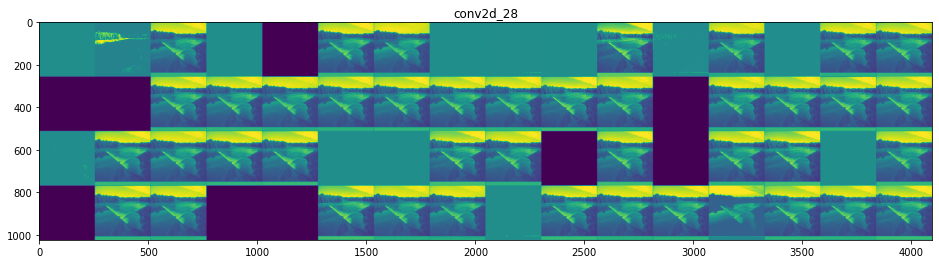

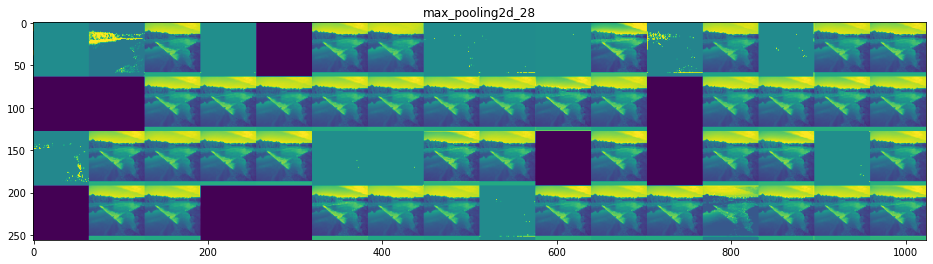

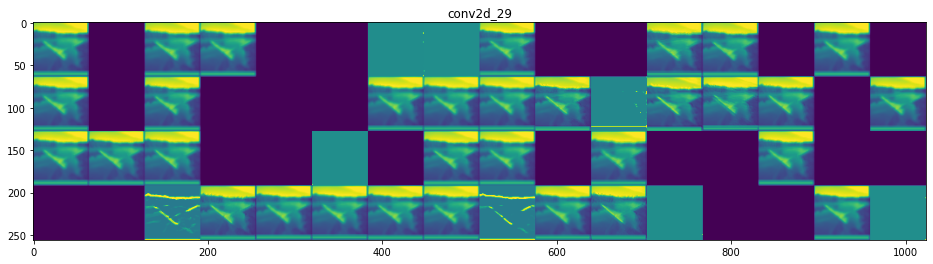

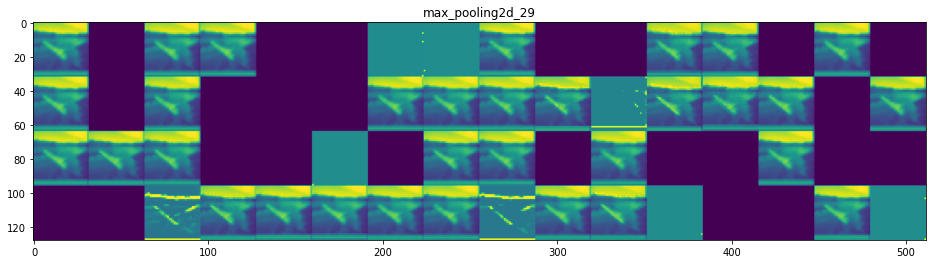

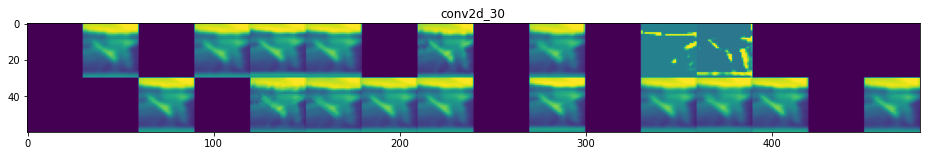

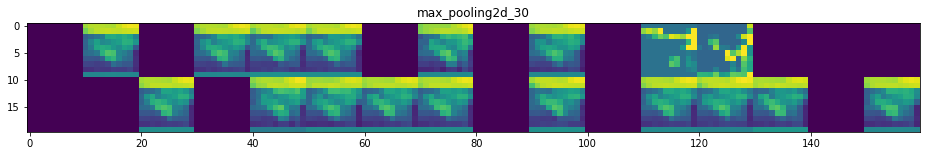

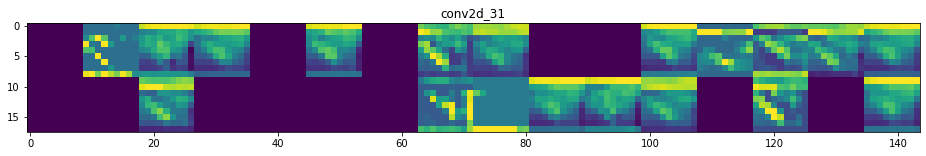

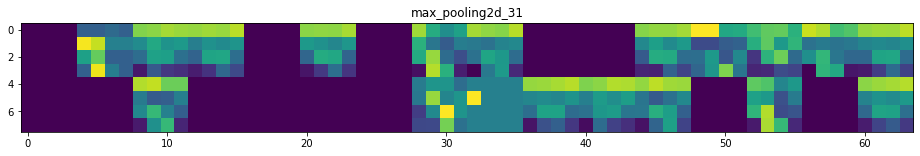

In [167]:
import matplotlib.pyplot as plt

layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    print(layer_name)
    if ("Dense" in layer_name): break

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')